In [84]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from baseline import baseline 
#import peakutils
#%matplotlib inline 

In [273]:
date='Feb-15-2023'
fpath=r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\UoB-PostDoc\Spectral Data'
fname='2023 February 15 14_28_45.csv'
tstamp=fname[17: 25: 1] # timestamp portion of filename
#tstamp="15_36_17"
data = pd.read_csv(os.path.join(fpath,date,fname),engine='python',header=None)
wavelength=data.iloc[0]
wavelegnth=wavelength[150:]
data=data.to_numpy()
d=data[1::2,150:]    #even rows hold intensity data
len(d)
print(tstamp)

14_28_45


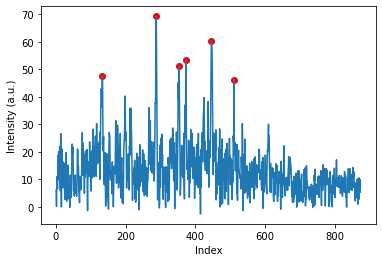

[132 287 352 372 445 510]
132    635.886436
287    641.677540
352    644.098333
372    644.842252
445    647.553743
510    649.962973
Name: 0, dtype: float64


In [274]:
# Peak picking parameters
h2=6000 # max height
w1=1 # min width
w2=20 # max width
prom1=6 # min prominance
prom2=1000000 # max prominance
dis=5 # seperation distance
nl=5 #noise level threshold 
maxp=15 # maximum number of peaks to find

# Test frame 
i=30 # Frame
#spec=d[i]
spec=d[i]-baseline(d[i],25) # remove basline with degree (25) polynomial 
h1=np.mean(spec[-100:])*nl # min height is 1.x*basline noise on long wavelength end
indices = find_peaks(spec,height=[h1,h2],prominence=[prom1,prom2],width=[w1,w2],wlen=10,distance=dis)[0] #d,prominence=[prom1,prom2],width=[w1,w2],
if len(indices) < maxp: # decrease the number of peaks by increaseing the min prominance if too many peaks are found 
    indices=indices
else:
    while len(indices) > maxp:
        prom1=prom1*1.05
        indices = find_peaks(spec,height=[h1,h2],prominence=[prom1,prom2],wlen=10,distance=dis)[0] #d,prominence=[prom1,prom2],width=[w1,w2],
index=np.linspace(1,len(spec),num=len(spec))
index=index.T
plt.plot(index,spec)
plt.scatter(indices,[spec[j] for j in indices],color='red')  
plt.xlabel('Index')
plt.ylabel('Intensity (a.u.)')
plt.show()
print(indices)
peak_position=wavelength[indices]
print(peak_position)

# np.savetxt('wavelength.csv',wavelength)
# np.savetxt('CERS.csv',d[i])

In [275]:
# Peak Picking with Parabolic Interpolation
i=0
out=[1,0] # set dummy input for shape - remove first row upon export of data
outp=[0,0]
while i < len(d): # Loop through all spectra for this event
    prom=prom1 # min prominance
    #spec=d[i]
    
    spec=d[i]-baseline(d[i],25) # remove basline with degree (25) polynomial 
    h1=np.mean(spec[-100:])*nl # min height is 1.x*basline noise on long wavelength end
    indices = find_peaks(spec,height=[h1,h2],prominence=[prom,prom2],width=[w1,w2],wlen=10,distance=dis)[0]
    if len(indices) < maxp: # decrease the number of peaks by increaseing the min prominance if too many peaks are found 
        peak_position=wavelength[indices]
    else:
        while len(indices) > maxp:
            prom=prom*1.05
            indices = find_peaks(spec,height=[h1,h2],prominence=[prom,prom2],width=[w1,w2],wlen=10,distance=dis)[0]
        peak_position=wavelength[indices]
    num=np.repeat(i+1,len(peak_position))
    outdata = np.column_stack([num, peak_position])
    out=np.vstack((out,outdata)) # join peaks from all frames 
    wave=wavelength
    ints=spec
    for k in range(len(peak_position)):
        wls = [wave[indices[k]-1],wave[indices[k]],wave[indices[k]+1]]
        intensity = [ints[indices[k]-1],ints[indices[k]],ints[indices[k]+1]]
        d1 = intensity[1]- intensity[0]
        d2 = intensity[2] - (2*intensity[1]) + intensity[0]
        pmax = wls[2]-((wls[2]-wls[1])*((d1/d2)+1.5)) #finds new maximum by parabolic interpolation
        outpdata2 = np.column_stack([i+1, pmax])
        outp=np.vstack((outp,outpdata2)) # join peaks from all frames
    i=i+1
#datafile_path = fpath+'/peakdata/'+date+tstamp+'peaks.dat' # generate .dat file 
#np.savetxt(datafile_path , out[1:len(out)+1], fmt=['%1.3f','%1.3f']) # save .dat to peakdata folder - 3 decimal places
datapfile_path =os.path.join(r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\UoB-PostDoc\HOT-data\peakdata') # generate .dat file 
fname2=date+'_'+tstamp+'parpeaks.dat'
np.savetxt(os.path.join(datapfile_path,fname2), outp[1:len(outp)+1], fmt=['%1.3f','%1.3f']) # save .dat to peakdata folder - 3 decimal places

Text(0, 0.5, 'Peak Position (nm)')

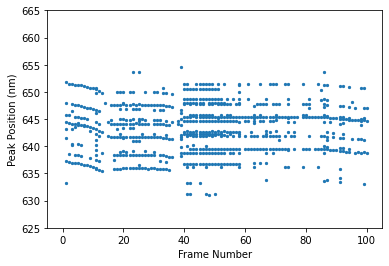

In [276]:
# Plot peak positions for each frame
p=outp.T
plt.scatter(p[0],p[1],s=5)
plt.ylim([625,665])
plt.xlabel("Frame Number")
plt.ylabel("Peak Position (nm)")